In [4]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn import utils
from sklearn.svm import SVC
import csv
from tqdm import tqdm
import multiprocessing
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import os
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
df = pd.read_csv("PubMed.csv")

In [6]:
df.head()

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0
3,Multilayer capsules: a promising microencapsul...,"In 1980, Lim and Sun introduced a microcapsule...","['Acrylic Resins', 'Alginates', 'Animals', 'Bi...",11426874,"[['D05.750.716.822.111', 'D25.720.716.822.111'...","['Chemicals and Drugs [D]', 'Technology, Indus...",1,1,1,1,1,0,1,0,0,1,0,0,0,0
4,"Nanohydrogel with N,N'-bis(acryloyl)cystine cr...",Substantially improved hydrogel particles base...,"['Antineoplastic Agents', 'Cell Proliferation'...",28323099,"[['D27.505.954.248'], ['G04.161.750', 'G07.345...","['Chemicals and Drugs [D]', 'Phenomena and Pro...",1,1,0,1,1,0,1,0,0,1,0,0,0,0


In [7]:
print("The total number of articles taken from the Bioasq dataset =",len(df))

The total number of articles taken from the Bioasq dataset = 50000


In [8]:
print('Average Article length: ', df.abstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.abstractText.str.split().str.len().std())

Average Article length:  192.05284
Stdev Article length:  76.74764082329723


In [9]:
cols = df.columns
cols = list(df.columns)
MeshTitleCategories = cols[6:]
num_labels = len(MeshTitleCategories)
print('Mesh Labels Root Class: "\n"',MeshTitleCategories)
print("\n")
print('Number of Labels: ' ,num_labels)

Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [10]:
counts = []
for mesh_Heading_category in MeshTitleCategories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


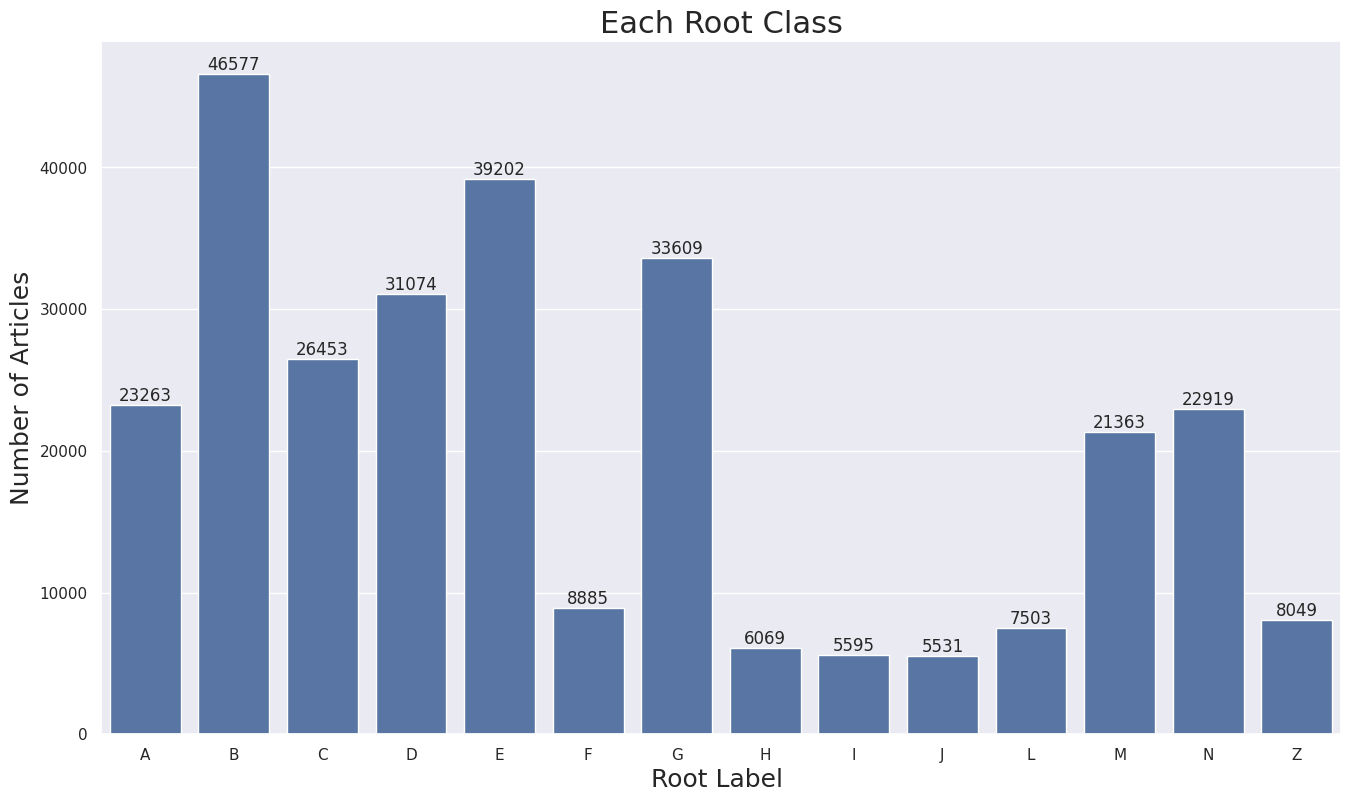

In [11]:
sns.set(font_scale=1)
plt.figure(figsize=(16, 9))


ax = sns.barplot(x=MeshTitleCategories, y=df.iloc[:, 6:].sum().values)

plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)


rects = ax.patches
labels = df.iloc[:, 6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [12]:
df['one_hot_labels'] = list(df[MeshTitleCategories].values)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,...,0,0,1,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,...,1,1,0,1,1,0,1,1,1,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]"
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,...,0,1,0,0,0,1,0,0,0,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"


In [13]:
Labels = list(df.one_hot_labels.values)
Article = list(df.abstractText.values)

In [14]:
array_of_arrays = np.array(Labels)
unique_arrays, indices = np.unique(array_of_arrays, axis = 0, return_index=True)

print("Unique labels: ")
print(len(unique_arrays))

Unique labels: 
3244


In [15]:
tokenized_documents = [word_tokenize(document.lower()) for document in Article]

tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(tokenized_documents)]

model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=8, epochs=3)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

vector_representation = model.infer_vector(tokenized_documents[0])

In [16]:
vector_representation

array([ 3.6006112e-02, -1.1178593e-01, -2.0939814e-02, -4.5322686e-02,
       -7.8680493e-02, -1.5357654e-01, -2.8722700e-02,  2.4072793e-01,
        4.0634912e-02, -1.6416927e-01,  6.5648858e-03, -5.2958790e-02,
       -2.5457811e-01,  9.1037199e-02,  7.1870731e-03, -2.5037663e-02,
       -4.2357747e-02, -2.4898525e-01, -2.9946601e-03, -1.7964917e-01,
        7.9798298e-03,  4.4923935e-02,  4.8644617e-02,  1.2654844e-02,
        8.5388310e-03,  1.4744065e-04, -9.8040134e-02,  4.9246907e-02,
        3.6390714e-02,  4.1333150e-02,  2.1455741e-01,  1.8549394e-02,
        9.2109419e-02,  3.0762514e-02, -2.4255704e-02, -1.5466009e-01,
       -1.0253952e-02, -6.5714397e-02,  7.5190410e-02, -1.1846172e-02,
       -6.0311984e-03, -1.3995261e-01, -1.1603625e-01,  8.0203451e-02,
       -1.0263634e-01,  2.7817916e-03, -2.0891581e-01, -1.4446139e-02,
        9.3410030e-02,  1.5977561e-01, -1.4465423e-02, -8.8834696e-02,
       -7.4305877e-02,  1.1492955e-01, -1.0154324e-02,  5.6797728e-02,
      

In [17]:
tagged_data[0]

TaggedDocument(words=['fifty-four', 'paraffin', 'embedded', 'tissue', 'sections', 'from', 'patients', 'with', 'dysplasia', '(', '21', 'cases', ')', 'and', 'with', 'cervical', 'cancer', '(', '33', 'cases', ')', 'were', 'analysed', '.', 'hpv', 'was', 'detected', 'and', 'identified', 'in', 'two', 'stages', '.', 'firstly', ',', 'using', 'mixed', 'starters', ',', 'chosen', 'genomic', 'dna', 'sequences', 'were', 'amplified', ';', 'secondly', 'the', 'material', 'thus', 'obtained', 'was', 'analyzed', 'by', 'hybridization', 'method', 'using', 'oligonucleotyde', '31-p', 'labelled', 'probe', '.', 'hpvs', 'of', 'type', '6', ',', '11', ',', '16', ',', '18', ',', '33', 'were', 'identified', '.', 'the', 'p-53', 'expression', 'was', 'assayed', 'by', 'immunohistochemical', 'method', '.', 'hpv', 'infection', 'was', 'often', 'associated', 'with', 'dysplasia', 'and', 'cervical', 'cancer', '.', 'in', 'cervical', 'cancer', 'mainly', 'hpv', '16', 'and', '18', 'with', 'high', 'oncogenic', 'potential', 'were',

In [18]:

doc_vectors = [model.infer_vector(word_tokenize(document.lower())) for document in Article]


pca = PCA(n_components=3)
doc_vectors_pca = pca.fit_transform(doc_vectors)

In [19]:
df = pd.DataFrame({"Text": Article, "Label": Labels, "Vector": doc_vectors_pca.tolist()})
df

,Text,Label,Vector
0,Fifty-four paraffin embedded tissue sections f...,"[0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[-0.09569716269529484, -0.17539229821688718, -..."
1,The present cross-sectional study was conducte...,"[0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]","[0.7524081384915744, 0.4657725571506397, -0.01..."
2,The occurrence of individual amino acids and d...,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]","[-0.4169040268797461, -0.13808569644970814, -0..."
3,"In 1980, Lim and Sun introduced a microcapsule...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]","[-0.09500638958088635, -0.27967554756181434, 0..."
4,Substantially improved hydrogel particles base...,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]","[-0.08334521699979015, -0.45058024180826756, 0..."
...,...,...,...
49995,BACKGROUND: A 21-year-old man was admitted to ...,"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]","[0.21816254786685316, 0.13359945312500845, -0...."
49996,Nephrotoxicity is the most troublesome complic...,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.8359978749555044, -0.07772804131636818, -0...."
49997,BACKGROUND: The aim of this study was to inves...,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]","[0.2811889957921872, 0.28519222641456465, -0.2..."
49998,OBJECTIVES: To describe the frequency of postn...,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]","[0.312930187122112, 0.812634976432584, -0.1745..."


In [20]:
df[['PCA1', 'PCA2', 'PCA3']] = pd.DataFrame(df['Vector'].to_list(), index=df.index)
df

# Convert the arrays in the "Label" column to strings
df['Label'] = df['Label'].apply(lambda x: str(x))

# Group by the concatenated "Label" column and calculate mean for "PCA1" and "PCA2"
grouped_df = df.groupby('Label')[['PCA1', 'PCA2', 'PCA3']].mean().reset_index()

print(grouped_df)

                              Label      PCA1      PCA2      PCA3
0     [0 0 0 0 0 0 0 0 0 0 0 0 0 0] -0.260015 -0.126055 -0.046082
1     [0 0 0 0 0 0 0 0 0 0 0 0 1 1] -0.419214  0.161590  0.145940
2     [0 0 0 0 0 0 0 0 0 0 0 1 1 1] -0.519006  0.267511  0.161445
3     [0 0 0 0 0 0 0 0 0 0 1 0 0 0] -0.227769  0.145921  0.264764
4     [0 0 0 0 0 0 0 0 0 0 1 0 0 1] -0.352798  0.044239  0.156602
...                             ...       ...       ...       ...
3239  [1 1 1 1 1 1 1 1 1 0 0 0 1 0]  0.328982 -0.269355 -0.273586
3240  [1 1 1 1 1 1 1 1 1 0 0 1 0 0] -0.403787 -0.049691 -0.142201
3241  [1 1 1 1 1 1 1 1 1 0 0 1 1 0]  0.221892  0.171891 -0.070838
3242  [1 1 1 1 1 1 1 1 1 1 0 1 1 1]  0.485685  0.374762  0.461803
3243  [1 1 1 1 1 1 1 1 1 1 1 1 1 0]  0.428915  0.881854  0.489739

[3244 rows x 4 columns]


<ipython-input-21-f132eb4571ed>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], cmap='viridis', s=1)
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


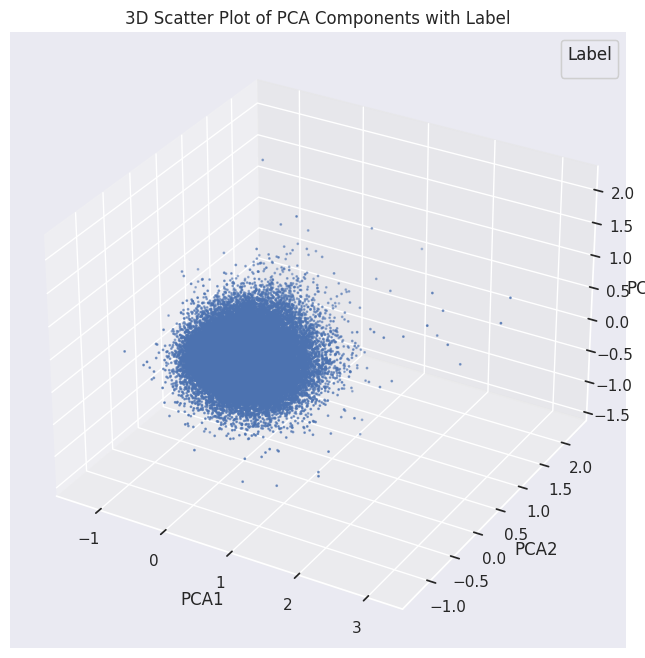

In [21]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with labels
scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], cmap='viridis', s=1)

# Add labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot of PCA Components with Label')

# Add colorbar
legend = ax.legend(*scatter.legend_elements(), title='Label')
ax.add_artist(legend)

# Show the plot
plt.show()

<ipython-input-22-4171768e3267>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], cmap='viridis', s=1)


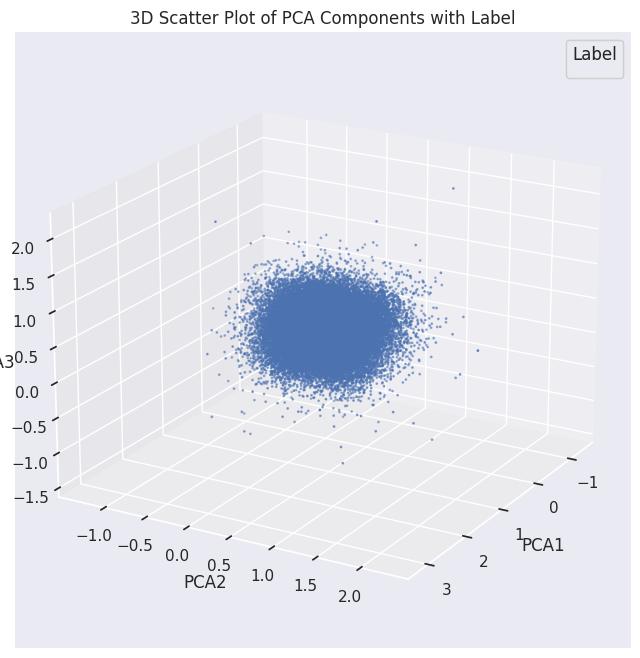

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with labels and reduced dot size (s=20 in this example)
scatter = ax.scatter(df['PCA1'], df['PCA2'], df['PCA3'], cmap='viridis', s=1)

# Add labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('3D Scatter Plot of PCA Components with Label')

# Add colorbar
legend = ax.legend(*scatter.legend_elements(), title='Label')
ax.add_artist(legend)

# Set a different view angle
ax.view_init(elev=20, azim=30)  # Adjust 'elev' and 'azim' as needed

# Show the plot
plt.show()

In [23]:
Labels = np.array(Labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(model.dv.vectors, Labels, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
multi_output_model = MultiOutputClassifier(logreg_model)
multi_output_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multi_output_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Test Accuracy: {accuracy:.2%}")

Accuracy: 0.0912
Test Accuracy: 9.12%


In [24]:
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(y_test.shape[1])])
print(report)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.70      0.73      4606
     Class 1       0.94      0.99      0.96      9276
     Class 2       0.81      0.81      0.81      5284
     Class 3       0.85      0.88      0.86      6157
     Class 4       0.79      0.97      0.87      7842
     Class 5       0.74      0.50      0.60      1762
     Class 6       0.77      0.89      0.82      6660
     Class 7       0.56      0.03      0.06      1272
     Class 8       0.63      0.31      0.42      1159
     Class 9       0.50      0.12      0.19      1141
    Class 10       0.61      0.20      0.30      1486
    Class 11       0.81      0.80      0.81      4280
    Class 12       0.78      0.72      0.75      4519
    Class 13       0.71      0.44      0.54      1651

   micro avg       0.81      0.78      0.80     57095
   macro avg       0.73      0.60      0.62     57095
weighted avg       0.80      0.78      0.77     57095
 sa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
LRaccuracies = []
for i in range(y_test.shape[1]):
    LRaccuracy_i = np.mean(y_test[:, i] == y_pred[:, i])
    LRaccuracies.append(LRaccuracy_i)

# Print the accuracy for each class
for i, acc in enumerate(LRaccuracies):
    print(f"Accuracy for Class {i}: {acc:.2%}")

Accuracy for Class 0: 75.73%
Accuracy for Class 1: 93.12%
Accuracy for Class 2: 79.71%
Accuracy for Class 3: 83.05%
Accuracy for Class 4: 78.01%
Accuracy for Class 5: 88.11%
Accuracy for Class 6: 74.63%
Accuracy for Class 7: 87.36%
Accuracy for Class 8: 89.93%
Accuracy for Class 9: 88.61%
Accuracy for Class 10: 86.23%
Accuracy for Class 11: 83.56%
Accuracy for Class 12: 77.93%
Accuracy for Class 13: 87.76%


In [26]:
NNmodel = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(14, activation='sigmoid')  # Sigmoid activation for multi-label classification
])

# Compile the model
NNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
NNmodel.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = NNmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2%}")

Epoch 1/20
1000/1000 [==============================] - 3s 2ms/step - loss: 0.4066 - accuracy: 0.4083 - val_loss: 0.3676 - val_accuracy: 0.4074
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3609 - accuracy: 0.3951 - val_loss: 0.3585 - val_accuracy: 0.3979
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3544 - accuracy: 0.3909 - val_loss: 0.3545 - val_accuracy: 0.3879
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3505 - accuracy: 0.3904 - val_loss: 0.3514 - val_accuracy: 0.4025
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3477 - accuracy: 0.3888 - val_loss: 0.3500 - val_accuracy: 0.4044
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3456 - accuracy: 0.3887 - val_loss: 0.3486 - val_accuracy: 0.3965
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3437 - accuracy: 0.3885 - val_loss: 0.3472 - val_accuracy:

In [27]:
NN1class_accuracies = []
for i in range(y_test.shape[1]):
    NN1class_accuracy = np.mean((y_test[:, i] == (y_pred[:, i] > 0.5).astype(int)))
    NN1class_accuracies.append(NN1class_accuracy)

# Print the accuracy for each class
for i, acc in enumerate(NN1class_accuracies):
    print(f"Accuracy for Class {i}: {acc:.2%}")

Accuracy for Class 0: 75.73%
Accuracy for Class 1: 93.12%
Accuracy for Class 2: 79.71%
Accuracy for Class 3: 83.05%
Accuracy for Class 4: 78.01%
Accuracy for Class 5: 88.11%
Accuracy for Class 6: 74.63%
Accuracy for Class 7: 87.36%
Accuracy for Class 8: 89.93%
Accuracy for Class 9: 88.61%
Accuracy for Class 10: 86.23%
Accuracy for Class 11: 83.56%
Accuracy for Class 12: 77.93%
Accuracy for Class 13: 87.76%


In [28]:
complex1NNmodel = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization
    tf.keras.layers.Dense(14, activation='sigmoid')  # Sigmoid activation for multi-label classification
])

# Compile the model
complex1NNmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
complex1NNmodel.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
y_pred = complex1NNmodel.predict(X_test)

Epoch 1/30
1000/1000 [==============================] - 5s 4ms/step - loss: 0.4693 - accuracy: 0.3990 - val_loss: 0.3996 - val_accuracy: 0.4219
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4225 - accuracy: 0.4163 - val_loss: 0.3895 - val_accuracy: 0.4254
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4120 - accuracy: 0.4146 - val_loss: 0.3833 - val_accuracy: 0.4201
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4075 - accuracy: 0.4155 - val_loss: 0.3812 - val_accuracy: 0.4151
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4042 - accuracy: 0.4146 - val_loss: 0.3776 - val_accuracy: 0.4274
Epoch 6/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4021 - accuracy: 0.4158 - val_loss: 0.3759 - val_accuracy: 0.4291
Epoch 7/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4007 - accuracy: 0.4167 - val_loss: 0.3743 - val_accuracy:

In [29]:
loss, accuracy = complex1NNmodel.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2%}")

# Calculate accuracy for each class
NN2accuracies = []
for i in range(y_test.shape[1]):
    NN2class_accuracy = np.mean((y_test[:, i] == (y_pred[:, i] > 0.5).astype(int)))
    NN2accuracies.append(NN2class_accuracy)

# Print the accuracy for each class
for i, acc in enumerate(NN2accuracies):
    print(f"Accuracy for Class {i}: {acc:.2%}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3683 - accuracy: 0.4137
Test Accuracy: 41.37%
Accuracy for Class 0: 75.52%
Accuracy for Class 1: 92.99%
Accuracy for Class 2: 79.79%
Accuracy for Class 3: 84.69%
Accuracy for Class 4: 78.42%
Accuracy for Class 5: 88.35%
Accuracy for Class 6: 75.93%
Accuracy for Class 7: 87.28%
Accuracy for Class 8: 89.80%
Accuracy for Class 9: 88.59%
Accuracy for Class 10: 85.15%
Accuracy for Class 11: 84.40%
Accuracy for Class 12: 78.27%
Accuracy for Class 13: 87.32%


In [30]:
svm_classifier = MultiOutputClassifier(SVC())

# Fit the classifier to the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

# Calculate accuracy for each label
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Accuracy: {svm_accuracy}")

Accuracy: 0.1105


In [31]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      4606
           1       0.94      1.00      0.97      9276
           2       0.83      0.82      0.82      5284
           3       0.88      0.88      0.88      6157
           4       0.79      1.00      0.88      7842
           5       0.80      0.53      0.64      1762
           6       0.80      0.88      0.84      6660
           7       1.00      0.00      0.00      1272
           8       0.68      0.31      0.43      1159
           9       0.68      0.04      0.08      1141
          10       0.76      0.17      0.28      1486
          11       0.82      0.86      0.84      4280
          12       0.80      0.72      0.76      4519
          13       0.74      0.47      0.57      1651

   micro avg       0.83      0.79      0.81     57095
   macro avg       0.81      0.60      0.62     57095
weighted avg       0.83      0.79      0.78     57095
 samples avg       0.83   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy for each class
svm1accuracies = []
for i in range(y_test.shape[1]):
    svm1class_accuracy = np.mean((y_test[:, i] == (y_pred[:, i] > 0.5).astype(int)))
    svm1accuracies.append(svm1class_accuracy)

# Print the accuracy for each class
for i, acc in enumerate(svm1accuracies):
    print(f"Accuracy for Class {i}: {acc:.2%}")

Accuracy for Class 0: 77.73%
Accuracy for Class 1: 93.36%
Accuracy for Class 2: 81.24%
Accuracy for Class 3: 85.03%
Accuracy for Class 4: 78.59%
Accuracy for Class 5: 89.40%
Accuracy for Class 6: 77.22%
Accuracy for Class 7: 87.30%
Accuracy for Class 8: 90.32%
Accuracy for Class 9: 88.85%
Accuracy for Class 10: 86.87%
Accuracy for Class 11: 85.87%
Accuracy for Class 12: 79.27%
Accuracy for Class 13: 88.56%


In [33]:
from transformers import BartForConditionalGeneration, BartTokenizer

In [34]:
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Define function for summarization
def summarize_text(text, max_length=150):
    # Tokenize input text
    inputs = tokenizer([text], max_length=1024, return_tensors='pt', truncation=True)

    # Generate summary
    summary_ids = model.generate(inputs.input_ids, max_length=max_length, num_beams=4, early_stopping=True)

    # Decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return summary

# Example summarization for the first abstract
abstract = df['Text'][0]

# Generate summary
summary = summarize_text(abstract)

print("Original Abstract:")
print(abstract)
print("\n")
print("Summarized Abstract:")
print(summary)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Original Abstract:
Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 16, 18, 33 were identified. The p-53 expression was assayed by immunohistochemical method. HPV infection was often associated with dysplasia and cervical cancer. In cervical cancer mainly HPV 16 and 18 with high oncogenic potential were found. The p-53 was present rarely, and in minute quantities. No correlation was observed between presence of p-53 and HPVs DNA.


Summarized Abstract:
Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. In cervical ca